In [ ]:
import kagglehub
import os
import shutil
def download_data():
    path = kagglehub.dataset_download("pandrii000/hituav-a-highaltitude-infrared-thermal-dataset")

    print("Path to dataset files:", path)

    os.makedirs("tmp", exist_ok=True) 
    subdir = os.path.join(path, "hit-uav")
    destination_path = os.path.join("tmp", "dataset")

    shutil.move(subdir, destination_path)

    print(f"Moved data from {subdir} to {destination_path}")

In [3]:
download_data()

100%|██████████| 191M/191M [00:58<00:00, 3.43MB/s] 

Extracting files...


Path to dataset files: C:\Users\creep\.cache\kagglehub\datasets\pandrii000\hituav-a-highaltitude-infrared-thermal-dataset\versions\1
Moved data from C:\Users\creep\.cache\kagglehub\datasets\pandrii000\hituav-a-highaltitude-infrared-thermal-dataset\versions\1\hit-uav to tmp\dataset


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
import torch
import torchvision
from torchvision.models.detection import FasterRCNN_ResNet50_FPN_Weights
import os
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image
from torch import optim
import numpy as np
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import fasterrcnn_mobilenet_v3_large_fpn

In [5]:
shutil.rmtree('drive/MyDrive/tmp')

FileNotFoundError: [WinError 3] System nie może odnaleźć określonej ścieżki: 'drive/MyDrive/tmp'

In [6]:
base_dirname = "tmp/dataset"
original_label_dirname = "labels"
filtered_label_dirname = "filtered_labels"
car_dirname = "cars"
bicycle_dirname = "bicycles"
persons_dirname = "persons"

for dirname in ["train", "val", "test"]:
    os.makedirs(os.path.join(base_dirname, filtered_label_dirname, dirname), exist_ok=True)
    os.makedirs(os.path.join(base_dirname, car_dirname, dirname), exist_ok=True)
    os.makedirs(os.path.join(base_dirname, bicycle_dirname, dirname), exist_ok=True)
    os.makedirs(os.path.join(base_dirname, persons_dirname, dirname), exist_ok=True)

    for filename in os.listdir(os.path.join(base_dirname, original_label_dirname, dirname)):
        persons = []
        cars = []
        bicycles = []
        all_objects = []
        with open(os.path.join(base_dirname, original_label_dirname, dirname, filename), "r") as f:
            lines = f.readlines()
        for line in lines:
            if line.startswith("0"):
                persons.append(line)
                all_objects.append(line)
            elif line.startswith("1"):
              #  line=line.split(" ")
              #  line[0]="0"
               # line=" ".join(line)
                cars.append(line)
                all_objects.append(line)
            elif line.startswith("2"):
              #  line=line.split(" ")
               # line[0]="0"
               # line=" ".join(line)
                bicycles.append(line)
                all_objects.append(line)
        with open(os.path.join(base_dirname, filtered_label_dirname, dirname, filename), "w") as f:
            for line in all_objects:
                f.write(line)
        with open(os.path.join(base_dirname, car_dirname, dirname, filename), "w") as f:
            for line in cars:
                f.write(line)
        with open(os.path.join(base_dirname, bicycle_dirname, dirname, filename), "w") as f:
            for line in bicycles:
                f.write(line)
        with open(os.path.join(base_dirname, persons_dirname, dirname, filename), "w") as f:
            for line in persons:
                f.write(line)



In [ ]:
from PIL import Image
from PIL import ImageFilter, ImageOps
import cv2
import numpy as np
import matplotlib.pyplot as plt

base_dirname = "drive/MyDrive/tmp/dataset"
original_image_dirname = "images"
processed_image_dirname = "sobel_images"
for dirname in ["train", "val", "test"]:
    os.makedirs(os.path.join(base_dirname, processed_image_dirname, dirname), exist_ok=True)
    for filename in os.listdir(os.path.join(base_dirname, original_image_dirname, dirname)):
        image_path = os.path.join(base_dirname, original_image_dirname, dirname, filename)
        if image_path.endswith(".jpg"):
            with Image.open(image_path) as img:
                image_data = np.array(img)
                sobelx = cv2.Sobel(image_data, cv2.CV_64F, 1, 0, ksize=3)
                sobely = cv2.Sobel(image_data, cv2.CV_64F, 0, 1, ksize=3)
                sobelx = (sobelx - np.min(sobelx)) / (np.max(sobelx) - np.min(sobelx)) * 255
                sobely = (sobely - np.min(sobely)) / (np.max(sobely) - np.min(sobely)) * 255
                extended_image = np.stack((image_data, sobelx, sobely), axis=-1)
                sobel_image_path = os.path.join(base_dirname, processed_image_dirname, dirname, filename)
                plt.imsave(sobel_image_path, extended_image.astype(np.uint8))



FileNotFoundError: [Errno 2] No such file or directory: 'drive/MyDrive/tmp/dataset/images/train'

In [ ]:
class YoloDataset(Dataset):
    def __init__(self, images_dir, labels_dir, transforms=None):
        self.images_dir = images_dir
        self.labels_dir = labels_dir
        self.transforms = transforms
        self.images = []
        self.labels = []
        for f in os.listdir(labels_dir):
            image_file = f.replace('.txt', '.jpg')
            if not os.path.exists(os.path.join(images_dir, image_file)):
                continue
            if f.endswith('.txt'):
                with open(os.path.join(labels_dir, f), 'r') as file:
                    lines = file.readlines()
                    if lines:
                        self.labels.append(f)
                        self.images.append(image_file)


    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):

        img_name = self.images[idx]
        img_path = os.path.join(self.images_dir, img_name)
        image = Image.open(img_path).convert("RGB")
        w, h = image.size

        label_path = os.path.join(self.labels_dir, img_name.replace('.jpg', '.txt'))
        boxes = []
        labels = []

        if os.path.exists(label_path):
            with open(label_path, "r") as f:
                for line in f.readlines():
                    parts = line.strip().split()
                    class_id = int(parts[0])
                    x_center = float(parts[1]) * w
                    y_center = float(parts[2]) * h
                    width = float(parts[3]) * w
                    height = float(parts[4]) * h

                    x_min = x_center - width / 2
                    y_min = y_center - height / 2
                    x_max = x_center + width / 2
                    y_max = y_center + height / 2

                    boxes.append([x_min, y_min, x_max, y_max])
                    labels.append(class_id)

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        iscrowd = torch.zeros((len(boxes),), dtype=torch.int64)

        target = {
            "boxes": boxes,
            "labels": labels,
            "image_id": image_id,
            "area": area,
            "iscrowd": iscrowd
        }

        if self.transforms:
            image = self.transforms(image)

        return image, target

In [ ]:
from torchvision.transforms import ToTensor
dataset_train = YoloDataset(
    images_dir='drive/MyDrive/tmp/dataset/sobel_images/train',
    labels_dir='drive/MyDrive/tmp/dataset/filtered_labels/train',
    transforms=ToTensor()
)

dataest_val = YoloDataset(
    images_dir='drive/MyDrive/tmp/dataset/sobel_images/val',
    labels_dir='drive/MyDrive/tmp/dataset/filtered_labels/val',
    transforms=ToTensor()
)

dataset_test = YoloDataset(
    images_dir='drive/MyDrive/tmp/dataset/sobel_images/test',
    labels_dir='drive/MyDrive/tmp/dataset/filtered_labels/test',
    transforms=ToTensor()
)


from torch.utils.data import DataLoader

data_loader_train = DataLoader(dataset_train, batch_size=4, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))
data_loader_val = DataLoader(dataest_val, batch_size=4, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))
data_loader_test = DataLoader(dataset_test, batch_size=4, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))

In [ ]:
import torch
import torchvision.transforms as T
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import random
import numpy as np

def plot_boxes(ax, image_pil, boxes, labels, scores=None, class_names=None, title=""):
    """Helper function to draw boxes and labels on an image using Matplotlib."""
    ax.imshow(image_pil)
    ax.set_title(title)
    ax.axis('off')

    if class_names is None:
        class_names = {i: str(i) for i in range(1000)}

    for i, box in enumerate(boxes):
        xmin, ymin, xmax, ymax = box
        width, height = xmax - xmin, ymax - ymin
        rect = patches.Rectangle((xmin, ymin), width, height, linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)

        label_id = labels[i]
        label_text = class_names.get(label_id, f"ID: {label_id}") 

        if scores is not None:
            score = scores[i]
            label_text = f"{label_text}: {score:.2f}"

        ax.text(xmin, ymin - 5, label_text, color='white',
                bbox=dict(facecolor='red', alpha=0.6, pad=0)) 


def visualize_object_detection(
    model,
    dataset,
    idx=None,
    transform=None, 
    device=None,
    confidence_threshold=0.5,
    class_names=None, 
    iou_threshold_nms=0.5 
):

    if device is None:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    model.to(device)
    model.eval()

    if idx is None:
        idx = random.randint(0, len(dataset) - 1)

    try:
        img_pil, target = dataset
        idx=random.randint(0, len(img_pil)-1)
        img_pil=img_pil[idx]
        target = target[idx]
    except Exception as e:
        print(f"Error loading data at index {idx}: {e}")
        print("Ensure your dataset __getitem__ returns (PIL.Image, target_dict).")
        print("Target_dict should contain 'boxes': tensor(N,4) and 'labels': tensor(N).")
        return

    if not isinstance(img_pil, Image.Image):
        try:

            img_pil = T.ToPILImage()(img_pil.cpu())
        except Exception as e:
            print(f"Error: Input image is not PIL and could not be converted: {e}")
            print("Please ensure your dataset provides a PIL image or a tensor convertible to PIL.")
            return

    gt_boxes = target['boxes'].cpu().numpy()
    gt_labels = target['labels'].cpu().numpy()

    if transform:
        img_tensor = transform(img_pil)
    else:
        img_tensor = T.ToTensor()(img_pil)

    img_tensor_batch = img_tensor.unsqueeze(0).to(device)

    with torch.no_grad():
        predictions = model(img_tensor_batch)

    if not predictions or not isinstance(predictions, list) or not predictions[0]:
        print("Model did not return valid predictions.")
        pred_boxes, pred_labels, pred_scores = np.array([]), np.array([]), np.array([])
    else:
        pred_output = predictions[0]
        pred_boxes_all = pred_output['boxes'].cpu()
        pred_labels_all = pred_output['labels'].cpu()
        pred_scores_all = pred_output['scores'].cpu()

        keep_indices = pred_scores_all > confidence_threshold
        pred_boxes = pred_boxes_all[keep_indices].numpy()
        pred_labels = pred_labels_all[keep_indices].numpy()
        pred_scores = pred_scores_all[keep_indices].numpy()

   
        if iou_threshold_nms is not None and len(pred_boxes) > 0:
            from torchvision.ops import nms
            keep_nms_indices = nms(torch.from_numpy(pred_boxes), torch.from_numpy(pred_scores), iou_threshold_nms)
            pred_boxes = pred_boxes[keep_nms_indices.numpy()]
            pred_labels = pred_labels[keep_nms_indices.numpy()]
            pred_scores = pred_scores[keep_nms_indices.numpy()]


    fig, axes = plt.subplots(1, 2, figsize=(20, 10))

    plot_boxes(axes[0], img_pil, gt_boxes, gt_labels,
               class_names=class_names, title=f"Ground Truth (Image {idx})")

    plot_boxes(axes[1], img_pil, pred_boxes, pred_labels, pred_scores,
               class_names=class_names, title=f"Predictions (Conf > {confidence_threshold})")

    plt.tight_layout()
    plt.show()

In [ ]:
!pip install torchmetrics

  Using cached torchmetrics-1.7.1-py3-none-any.whl.metadata (21 kB)
  Using cached lightning_utilities-0.14.3-py3-none-any.whl.metadata (5.6 kB)
  Using cached nvidia_cuda_nvrtc_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-9.1.0.70-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.4.5.8-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.2.1.3-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.5.147-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.6.1.9-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.3.1.170-py3-none-manylinux2014_x86_64.wh

In [ ]:
from torchmetrics.detection.mean_ap import MeanAveragePrecision
from tqdm import tqdm
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print("Device:", device)


model = fasterrcnn_mobilenet_v3_large_fpn(weights=None)

num_classes = 3 + 1

in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
model.load_state_dict(torch.load("R-CNN-sobel.pth", map_location=device))
model.to(device)
model.eval()

Device: cpu


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): FrozenBatchNorm2d(16, eps=1e-05)
        (2): Hardswish()
      )
      (1): InvertedResidual(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
            (1): FrozenBatchNorm2d(16, eps=1e-05)
            (2): ReLU(inplace=True)
          )
          (1): Conv2dNormActivation(
            (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): FrozenBatchNorm2d(16, eps=1e-05)
          )
        )
      )
      (2): InvertedResidual(
        (block):

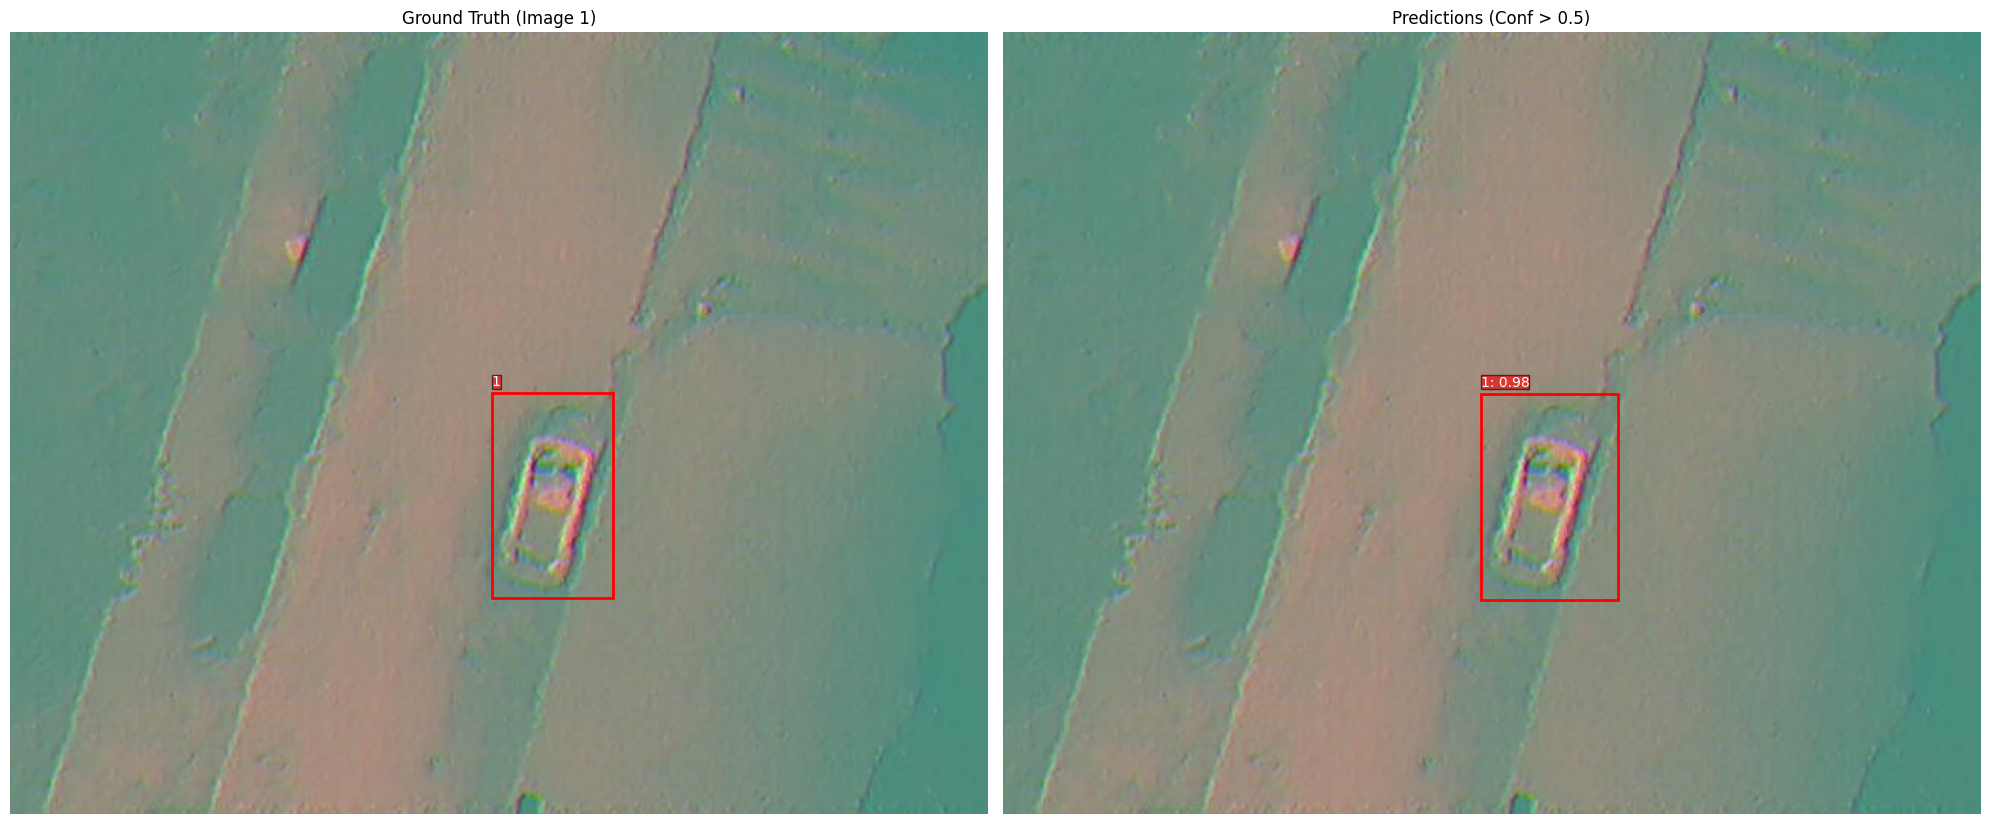

In [ ]:
visualize_object_detection(model, data_loader_test)

In [ ]:
ii=iter(data_loader_test)

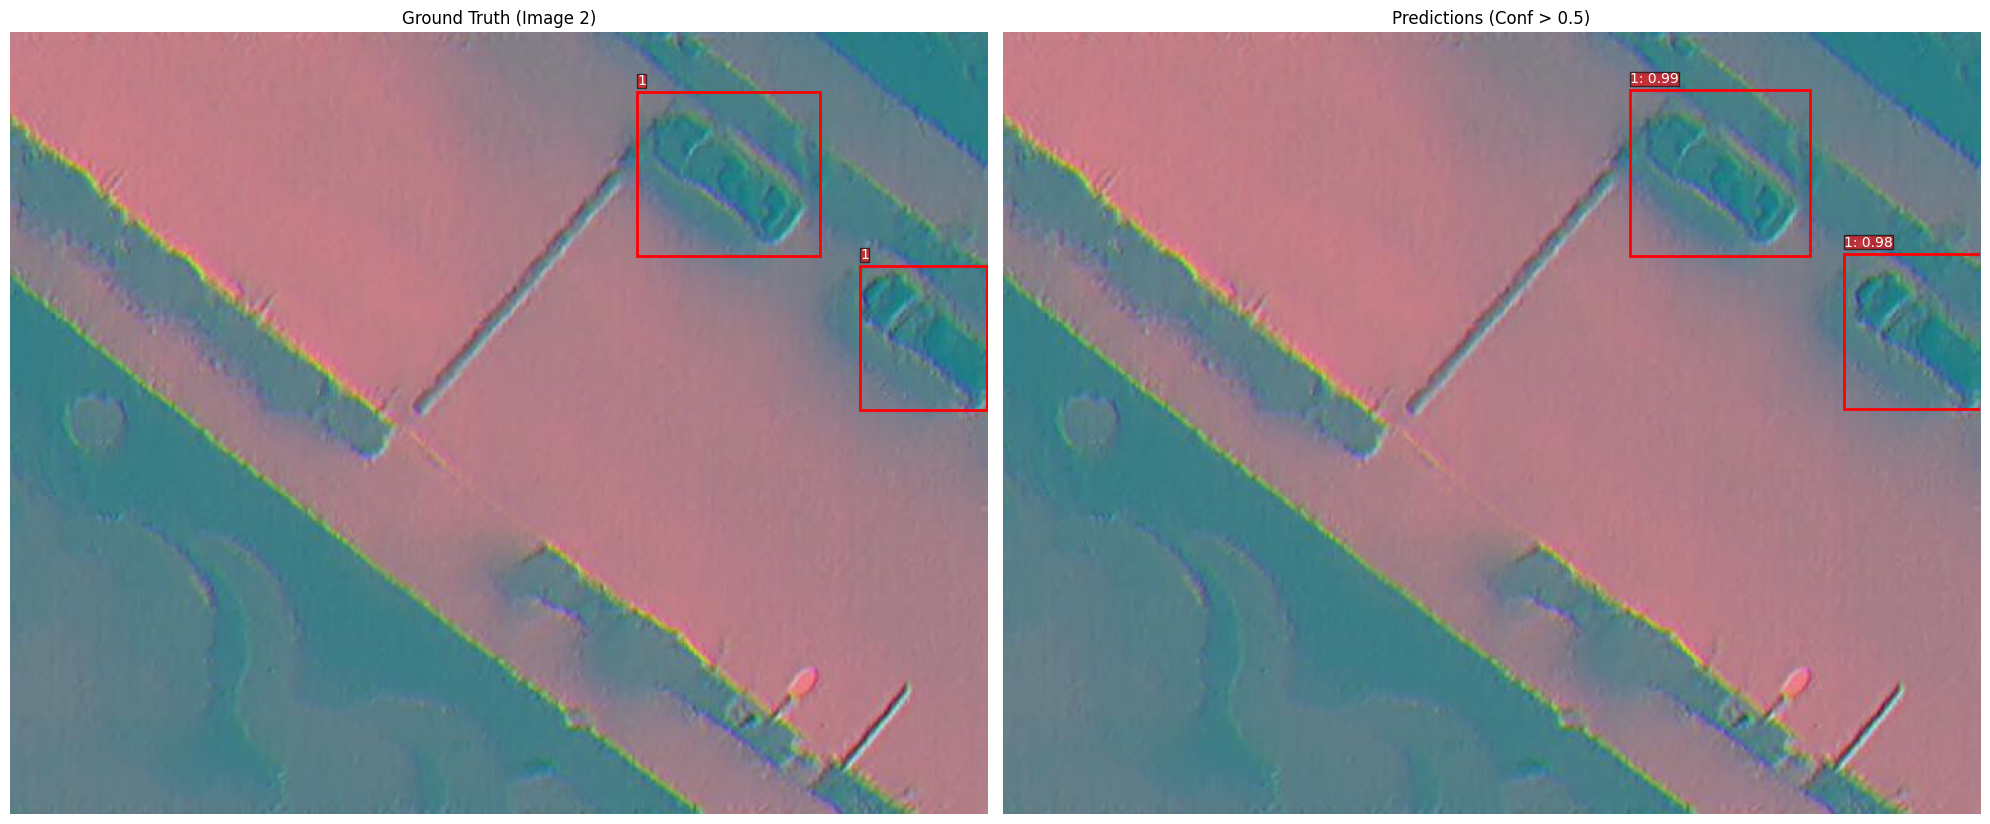

In [ ]:

D=next(ii)
visualize_object_detection(model, D)

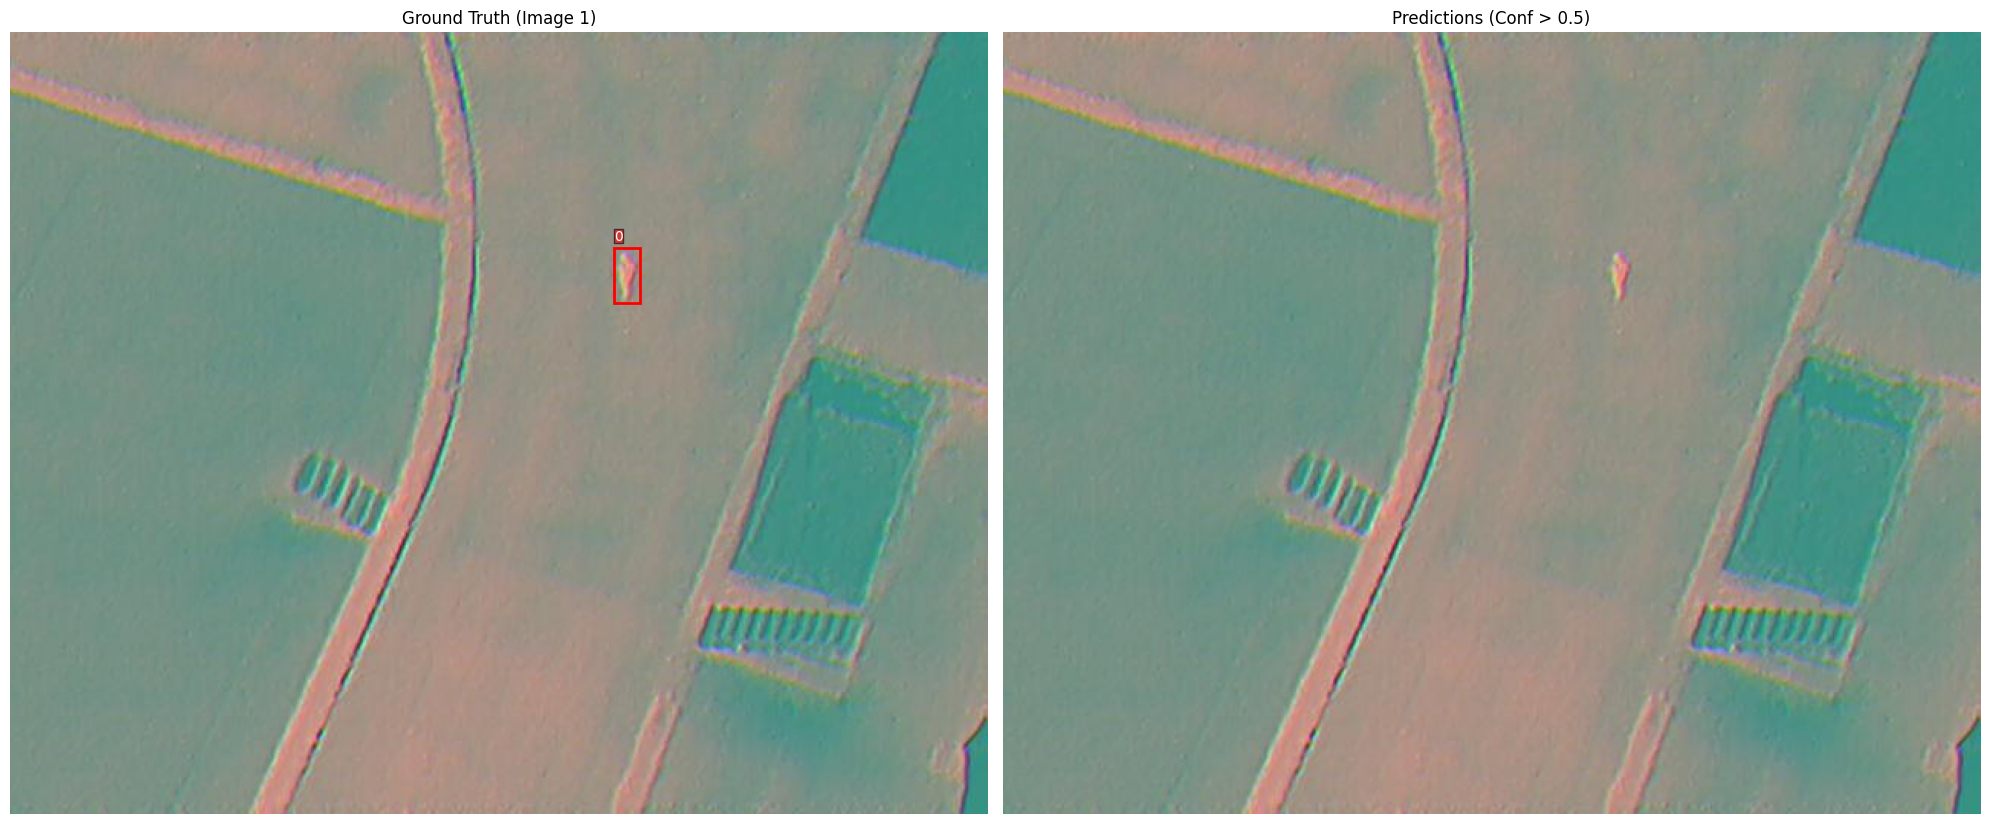

In [ ]:
visualize_object_detection(model, next(ii))

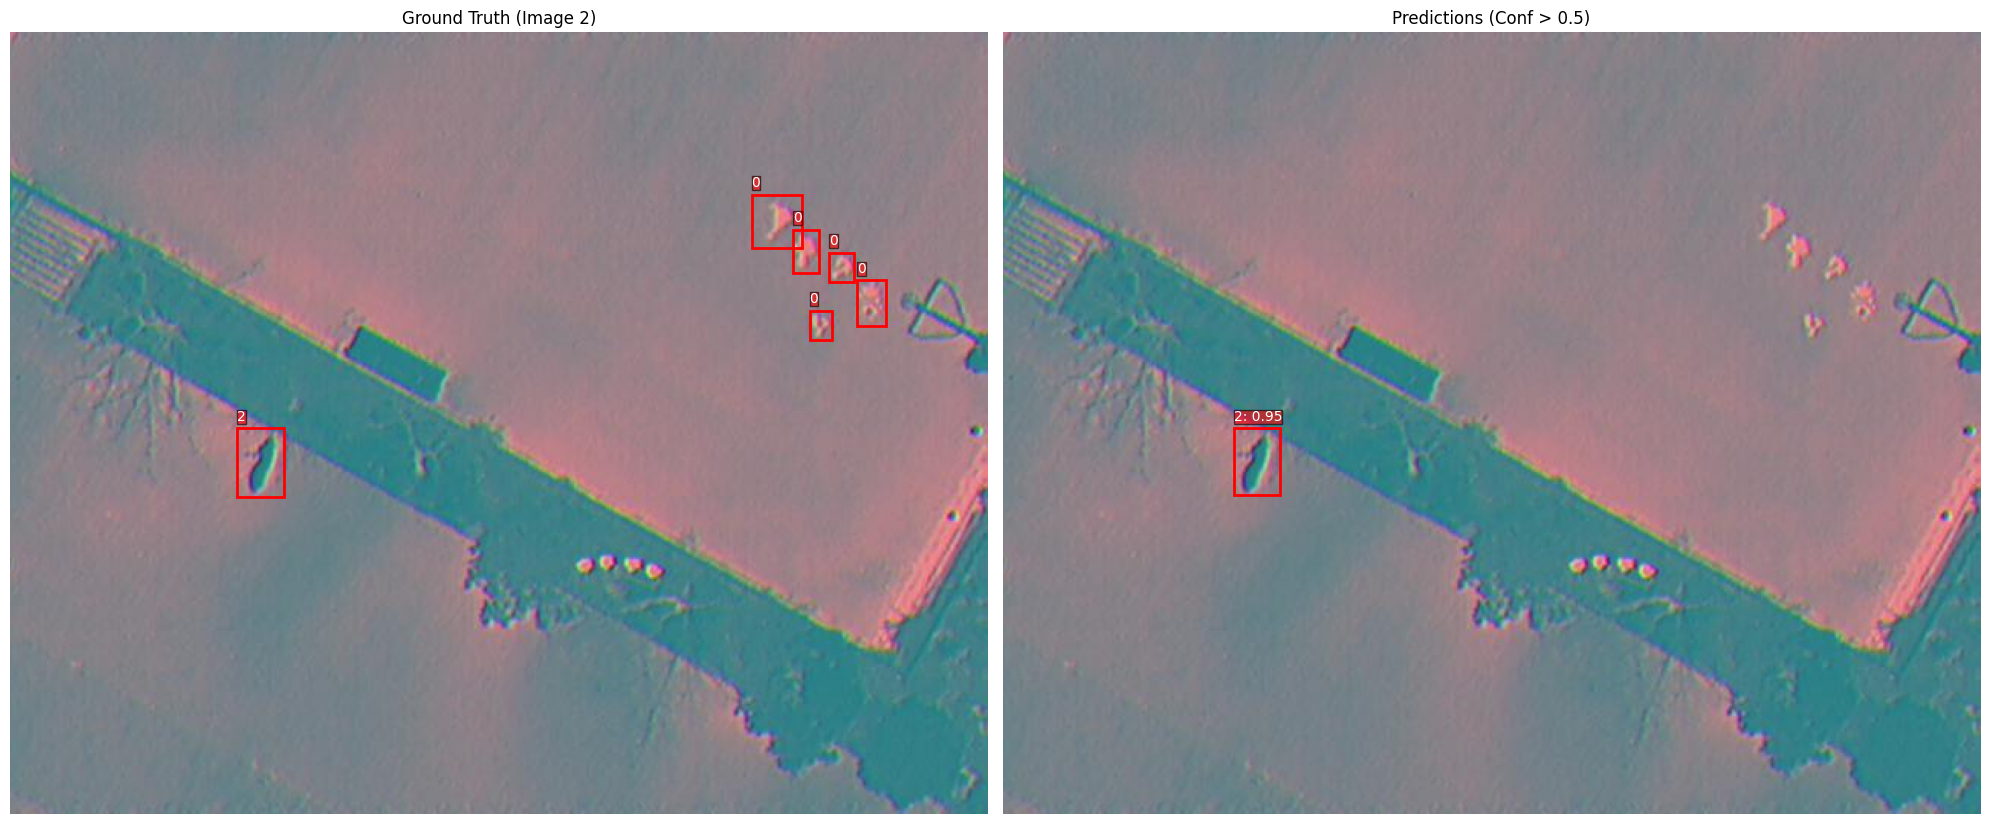

In [ ]:
visualize_object_detection(model, next(ii))

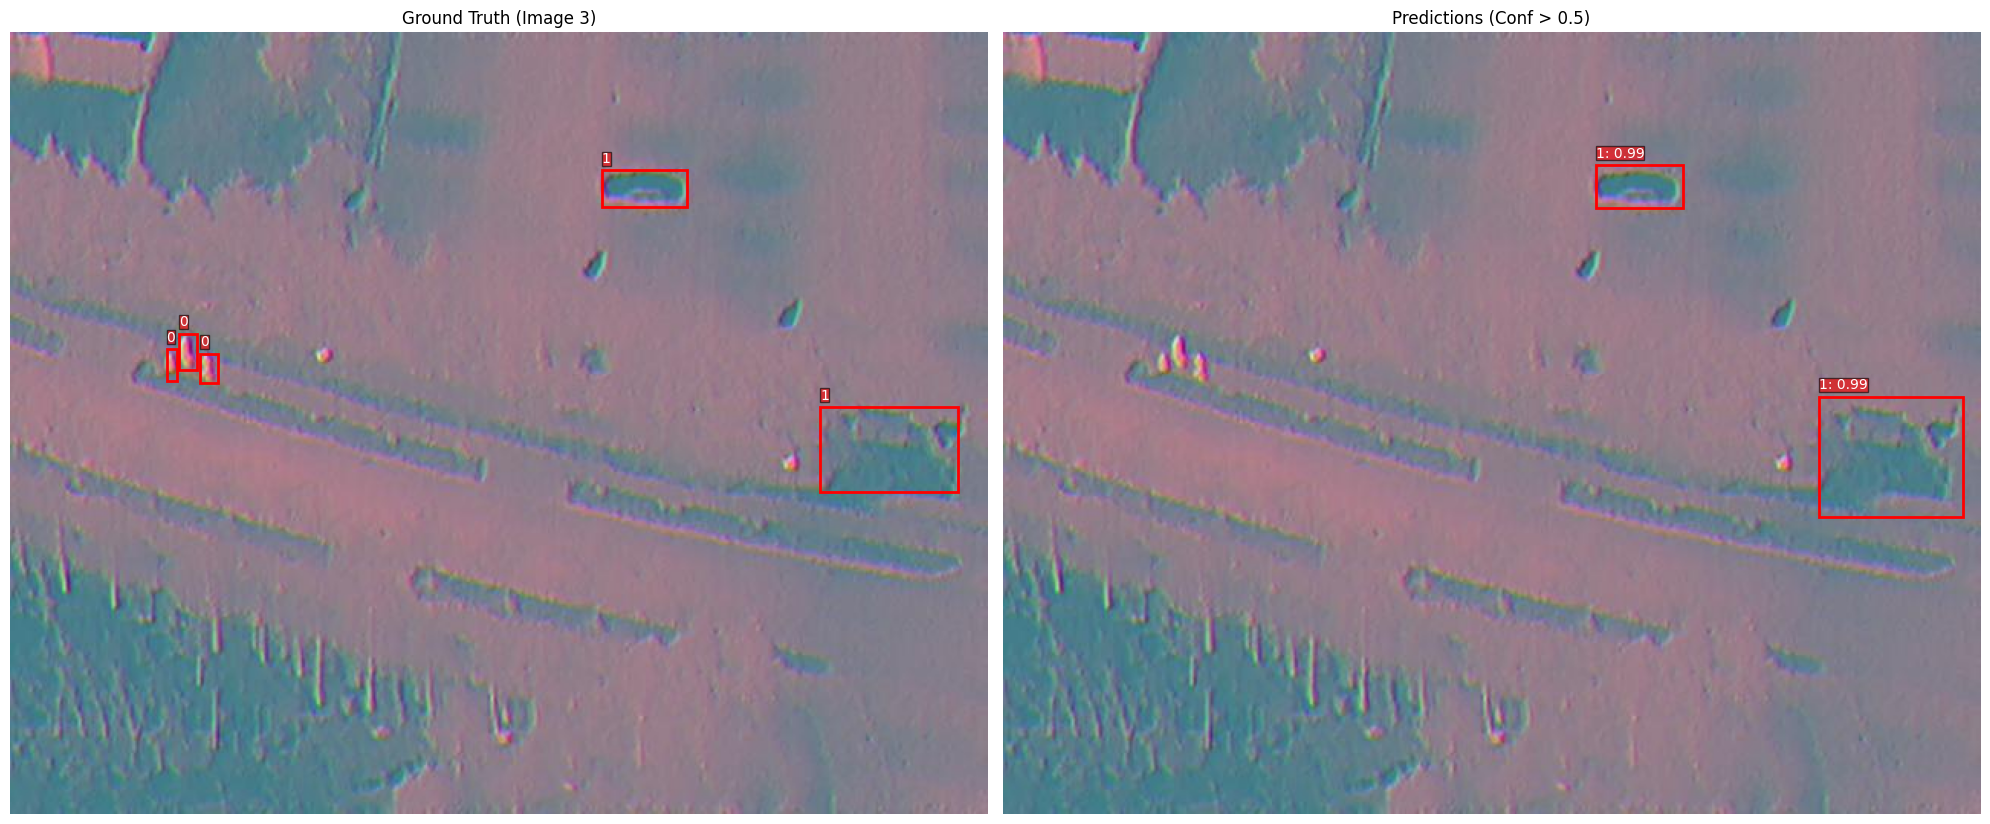

In [ ]:
visualize_object_detection(model, next(ii))

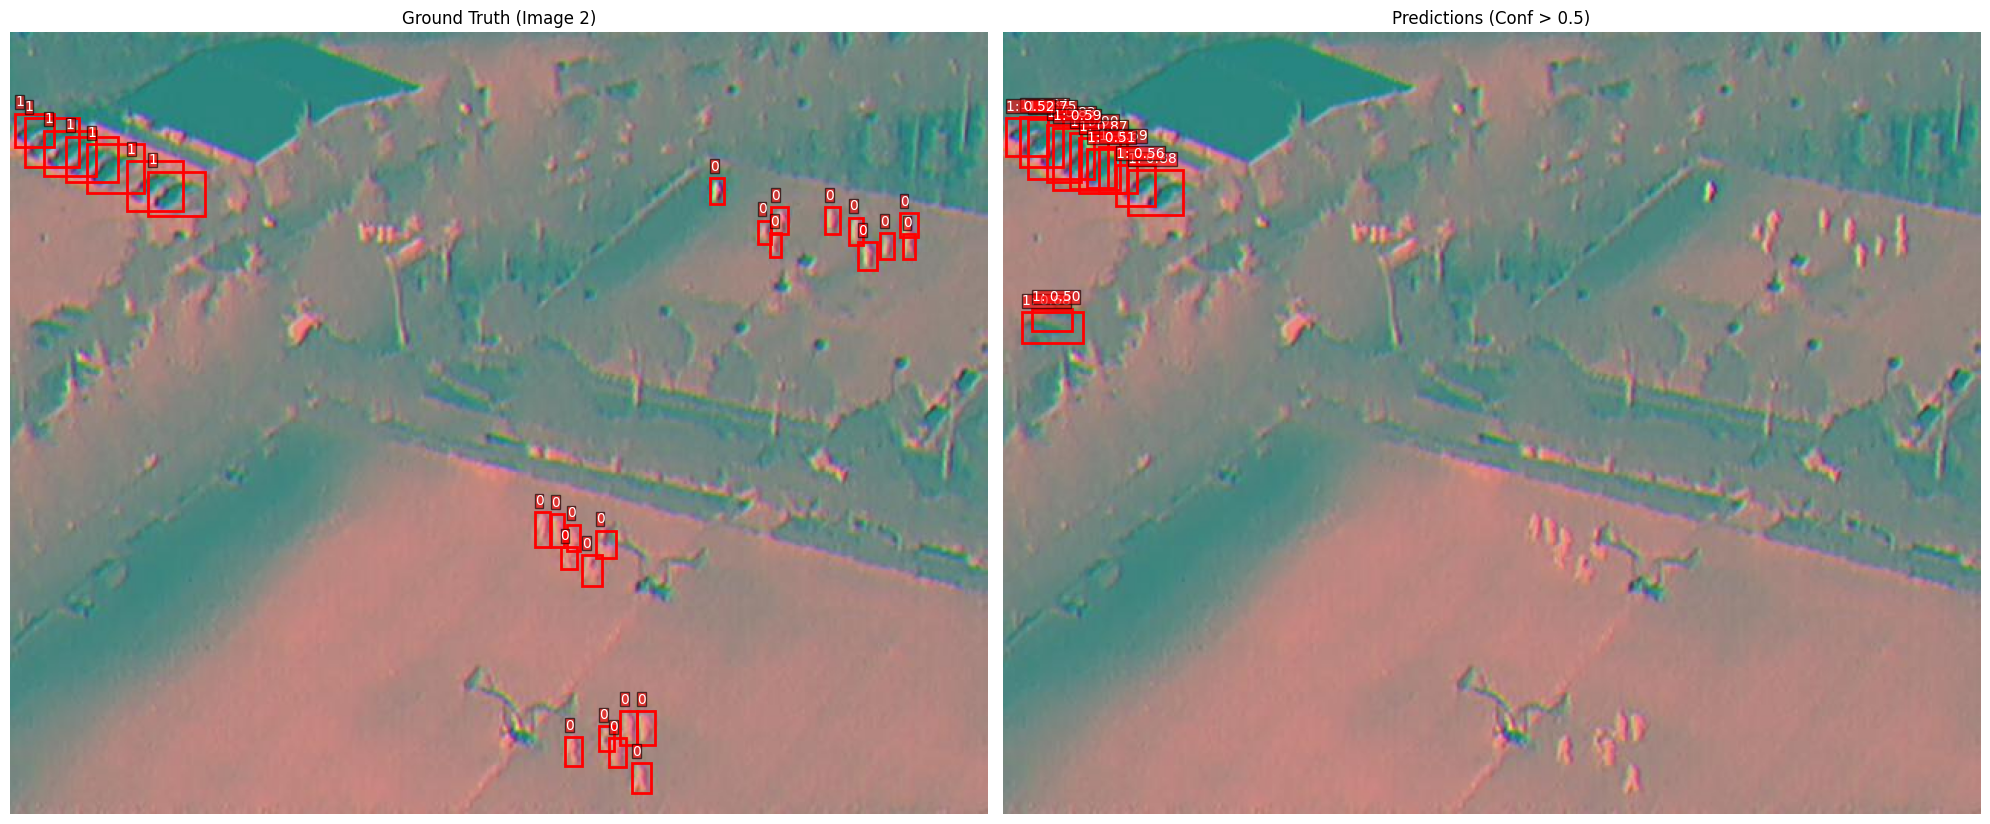

In [ ]:
visualize_object_detection(model, next(ii))

In [ ]:
mAP = MeanAveragePrecision(class_metrics=True)
i=0
with torch.no_grad():
    for images, targets in tqdm(data_loader_test):
        i+=1
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        outputs = model(images)
        mAP.update(outputs, targets)
mAP.compute()



100%|██████████| 142/142 [00:17<00:00,  8.13it/s]


{'map': tensor(0.2327),
 'map_50': tensor(0.4937),
 'map_75': tensor(0.1885),
 'map_small': tensor(0.1065),
 'map_medium': tensor(0.2985),
 'map_large': tensor(0.5979),
 'mar_1': tensor(0.0582),
 'mar_10': tensor(0.2341),
 'mar_100': tensor(0.3058),
 'mar_small': tensor(0.2004),
 'mar_medium': tensor(0.3644),
 'mar_large': tensor(0.7000),
 'map_per_class': tensor([0.0000, 0.4721, 0.2260]),
 'mar_100_per_class': tensor([0.0000, 0.5629, 0.3545]),
 'classes': tensor([0, 1, 2], dtype=torch.int32)}

In [ ]:
from utils import *

In [ ]:
data_loader = DataLoader(dataset_test, batch_size=1, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))
images, targets = next(iter(data_loader))
image = images[0]
target = targets[0]

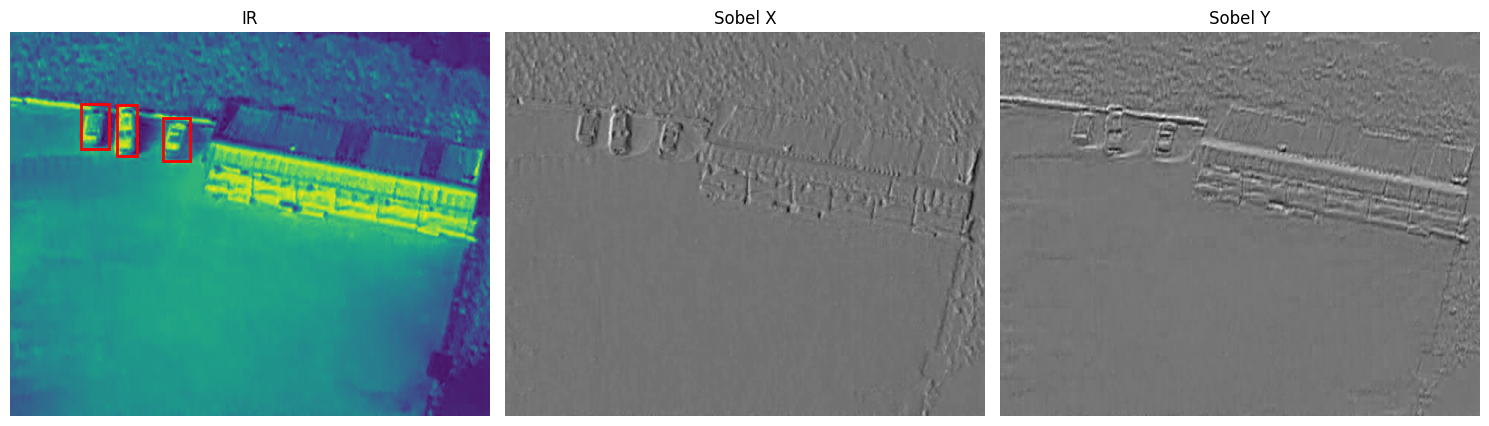

In [ ]:
from PIL import ImageDraw
import torchvision.transforms.functional as F
red_channel = image[0]
green_channel = image[1]
blue_channel = image[2]
red_img = F.to_pil_image(red_channel)
green_img = F.to_pil_image(green_channel)
blue_img = F.to_pil_image(blue_channel)

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].imshow(red_img, cmap='viridis',zorder=1)
for box in target['boxes'].tolist():

        xmin, ymin, xmax, ymax = box
        width = xmax - xmin
        height = ymax - ymin
        rect = plt.Rectangle(
        (xmin, ymin),  
        width, height,
        linewidth=2, edgecolor='red', facecolor='none',
        zorder=2
    )

        axs[0].add_patch(rect)
axs[0].set_title("IR")
axs[0].axis('off')

axs[1].imshow(green_img, cmap='gray')
axs[1].set_title("Sobel X")
axs[1].axis('off')

axs[2].imshow(blue_img, cmap='gray')
axs[2].set_title("Sobel Y")
axs[2].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
from torchvision.transforms import ToTensor
dataset_train = YoloDataset(
    images_dir='tmp/dataset/images/train',
    labels_dir='tmp/dataset/filtered_labels/train',
    transforms=ToTensor()
)

dataest_val = YoloDataset(
    images_dir='tmp/dataset/images/val',
    labels_dir='tmp/dataset/filtered_labels/val',
    transforms=ToTensor()
)

dataset_test = YoloDataset(
    images_dir='tmp/dataset/images/test',
    labels_dir='tmp/dataset/filtered_labels/test',
    transforms=ToTensor()
)


from torch.utils.data import DataLoader

data_loader_train = DataLoader(dataset_train, batch_size=4, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))
data_loader_val = DataLoader(dataest_val, batch_size=4, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))
data_loader_test = DataLoader(dataset_test, batch_size=4, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print("Device:", device)
from tqdm import tqdm

model = fasterrcnn_mobilenet_v3_large_fpn(weights=None)

num_classes = 3 + 1

in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
model.load_state_dict(torch.load("R-CNN.pth", map_location=device))
model.to(device)
model.eval()

Device: cuda


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): FrozenBatchNorm2d(16, eps=1e-05)
        (2): Hardswish()
      )
      (1): InvertedResidual(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
            (1): FrozenBatchNorm2d(16, eps=1e-05)
            (2): ReLU(inplace=True)
          )
          (1): Conv2dNormActivation(
            (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): FrozenBatchNorm2d(16, eps=1e-05)
          )
        )
      )
      (2): InvertedResidual(
        (block):

In [ ]:
with torch.no_grad():
    for images, targets in tqdm(data_loader_test):
        i+=1
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        outputs = model(images)
        mAP.update(outputs, targets)
mAP.compute()

100%|██████████| 142/142 [00:15<00:00,  8.98it/s]


{'map': tensor(0.2658),
 'map_50': tensor(0.5178),
 'map_75': tensor(0.2412),
 'map_small': tensor(0.1259),
 'map_medium': tensor(0.3369),
 'map_large': tensor(0.6505),
 'mar_1': tensor(0.0618),
 'mar_10': tensor(0.2542),
 'mar_100': tensor(0.3256),
 'mar_small': tensor(0.2161),
 'mar_medium': tensor(0.3905),
 'mar_large': tensor(0.7082),
 'map_per_class': tensor([0.0000, 0.5179, 0.2794]),
 'mar_100_per_class': tensor([0.0000, 0.5912, 0.3854]),
 'classes': tensor([0, 1, 2], dtype=torch.int32)}